Curve Fitting: Fitting counting data using Poisson statstics
============================================================

Introduction
------------

In experimental physics we often have a set of data and a model of the data, 
in the form of
some function. Parameters of the model can be obtained by matching the model
to the data. In modern physics this is done by adjusting the parameters of the model
to minimise some statistic. This usually requires a computer program, since 
the dependence of the model on its parameters is seldom linear, or solvable.

This process is usually referred to as "curve-fitting", and the statistic
to be determined is a "goodness of fit" value. (This is equivalent, 
under some conditions, to maximising the likelihood of the model).


The fitting program
-------------------

Fitting a curve to data is usually done by adjusting a set of parameters that characterise the curve in order 
to minimise a goodness of fit variable. When the pdf for the data is Poisson, we cannot use least squares fitting.

The likelihood function becomes
$$
l=\prod_{i=1}^N\,\frac{1}{n!}\lambda_i^n\,e^{-\lambda_i}
$$
and it is convenient to use the log of this, the log likelihood
$$
L=-\log l=\sum_{i=1}^N\, (\log n! -n\log\lambda_i+\lambda_i)
$$
where $i$ runs over the data points, $y_i$ is the value of the data at $x_i$ and $\lambda_i$ is the
model value which depends on $x_i$ and a set of parameters $\{p\}$. The uncertainty is determined by the Poisson statistics. The log likelihood must be minimised to optimise the values of the parameters.
No simple solution of this problem is known and the parameters must be adjusted iteratively in order to converge to a minimum.
This minimum might not be a global minimum, so a good set of starting parameters helps; a hand-drawn graph might help
in obtaining these. 

A detailed explanation of what this does and how to obtain and interpret the uncertainties is beyond the scope of these
notes. You are directed to a reference you should get to know, Numerical Recipes, *Press, Teukolsky, Vetterling, Flannery*,
Cambridge University Press.

In this notebook, we use `matplotlib` to plot and `lmfit` to do the fit. For further analysis we use
`corner` and `emcee`. The libraries `lmfit`, `corner` and `emcee` will probably need to be installed. For example, if you are using the Anaconda python distribution:
```
conda install -c conda-forge lmfit
conda install -c conda-forge corner
conda install -c conda-forge emcee
```

A data set
----------

We start by constructing a data set.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn, seed, poisson

In [14]:
N=50
x=np.linspace(0.0,10.0,N)
def gauss( x,x0,h0,sig,bkg):
    return h0*np.exp(-(x-x0)**2/(2.0*sig**2))+bkg

x0=4.5
sigx0=0.25
h0=40.0
sigh0=0.85
sig=1.1
sigsig=0.1
bkg=4.0
sigb=0.9

seed( 132465 )
#seed( 9653954 )
y=np.zeros(N)
for i in range(N):
    y[i]=gauss( x[i], sigx0*randn()+x0, sigh0*randn()+h0, sigsig*randn()+sig, sigb*randn()+bkg)

uy=y*0.1+1.5
#data=(x,y,uy)
#savetxt("gaussiandata.dat",array(data).T,fmt="%10.5f")

seed( 132465 )
y=np.zeros(N)
for i in range(N):
    y[i]=poisson(lam=gauss(x[i],x0,h0,sig,0))+poisson(lam=bkg)

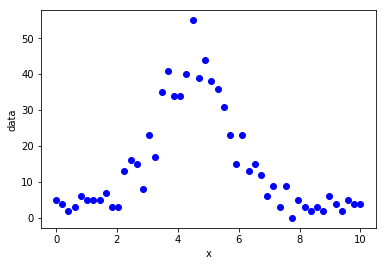

In [15]:
plt.plot(x,y,'bo')
plt.xlabel('x')
_=plt.ylabel('data')

We will use the gaussian function above as the model for the data. For the fitting process we first define the parameters that will be varied, then the objective "goodness of fit" function, in this case the log likelihood, assuming Poisson statistics. This returns a vector which is summed by the minimizer.

In [16]:
from scipy.special import gammaln
import lmfit

# the fit parameters: some starting values
param=lmfit.Parameters()
param.add('x0',value=3.5, min=1.0, max=float(N-1))
param.add('sig',value=2.0,min=0.0,max=5.0)
param.add('h0',value=20,min=3.0, max=100.0)
param.add('bkg',value=1.0,min=0.0,max=10.0)


def loglikelihood(param, x, data):
    p=param.valuesdict()
    model=gauss(x,p['x0'],p['h0'],p['sig'],p['bkg'])
    #return (np.sum(gammaln(data+1)-data*np.log(model)+model))
    return gammaln(data+1)-data*np.log(model)+model

Now use lmfit to do the fit. First define an instance of a `Minimizer` object, then do the fit.

We can't use the default Levenberg-Marquardt method, since this is specialised to least-squares problems,
so we must use a more general optimiser. I have chosen to use the constrained optimiser L-BFGS-B
(Limited-memory Broyden-Fletcher-Goldfarb-Shanno with simple Box constraints) -- the range of the parameters is constrained as this gives better performance in the Monte Carlo analysis below.

In [17]:
mcmin = lmfit.Minimizer(loglikelihood, param, fcn_args=(x,y))


In [18]:
result=mcmin.minimize(method='lbfgsb')

# calculate final result
final = y + result.residual

# write error report
lmfit.report_fit(result)

[[Fit Statistics]]
    # function evals   = 116
    # data points      = 50
    # variables        = 4
    chi-square         = 355.812
    reduced chi-square = 7.735
    Akaike info crit   = 106.119
    Bayesian info crit = 113.767
[[Variables]]
    x0:    4.54081928 (init= 3.5)
    sig:   1.10757391 (init= 2)
    h0:    40.1229977 (init= 20)
    bkg:   3.78215818 (init= 1)


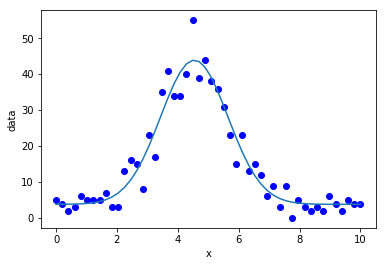

In [19]:
plt.plot(x,y,'bo')
plt.xlabel('x')
plt.ylabel('data')
minparam=result.params
p=minparam.valuesdict()
model=gauss(x,p['x0'],p['h0'],p['sig'],p['bkg'])
f=plt.plot(x,model)


[[Model]]
    Model(gauss)
[[Fit Statistics]]
    # function evals   = 141
    # data points      = 50
    # variables        = 4
    chi-square         = 714.730
    reduced chi-square = 15.538
    Akaike info crit   = 140.994
    Bayesian info crit = 148.642
[[Variables]]
    x0:    4.52466378 (init= 3.5)
    sig:   1.09760847 (init= 2)
    h0:    40.0023685 (init= 20)
    bkg:   3.91441232 (init= 1)



(<matplotlib.figure.Figure at 0x1a1db57f98>,
 <matplotlib.gridspec.GridSpec at 0x1a1da347f0>)

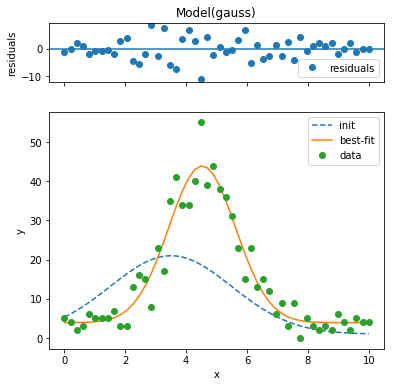

In [20]:
#Alternative plot from lmfit

model=lmfit.Model(gauss)
result=model.fit(y,x=x, params=param, method='lbfgsb')
print(result.fit_report())
result.plot()

---

Monte Carlo methods for uncertainty analysis
============================================

The code `lmfit` has methods for calculating the *Bayesian posterior probability* for the distribution of the fit parameters. In other words, the full probability distribution of each fit parameter is calculated, from which uncertainty ranges may be calculated. This uses the Monte Carlo program `emcee`. A graphic visualisation of these is generated by `corner`.

In [21]:
# MC for parameters: use the log likelihood function.
mcmin = lmfit.Minimizer(loglikelihood, result.params, fcn_args=(x,y))
res = mcmin.emcee(burn=300, steps=1000, thin=10, params=result.params)
print("done") # takes a while, needs some feedback.

done


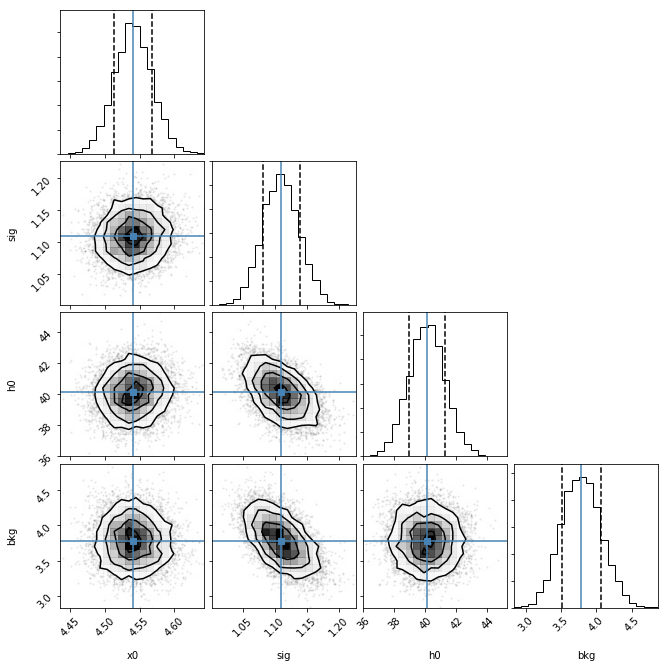

In [22]:
import corner
figure=corner.corner(res.flatchain, bins=20, quantiles=(0.16,0.84), 
                     labels=res.var_names, truths=list(res.params.valuesdict().values()))

In [23]:
lmfit.report_fit(res.params)

[[Variables]]
    x0:    4.54023985 +/- 0.027427 (0.60%) (init= 4.524664)
    sig:   1.10890631 +/- 0.028808 (2.60%) (init= 1.097608)
    h0:    40.0956145 +/- 1.179452 (2.94%) (init= 40.00237)
    bkg:   3.78044312 +/- 0.280612 (7.42%) (init= 3.914412)
[[Correlations]] (unreported correlations are <  0.100)
    C(sig, bkg)                  = -0.555 
    C(sig, h0)                   = -0.477 


In [24]:
# From lmfit manual ...
# find the maximum likelihood solution
highest_prob = np.argmax(res.lnprob)
hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
mle_soln = res.chain[hp_loc]
p=param
print("\nMaximum likelihood Estimation")
print('-----------------------------')
for i, par in enumerate(p):
    p[par].value = mle_soln[i]
    print(i, p[par])

# Finally lets work out a 1 and 2-sigma error estimate for 'h0'
quantiles = np.percentile(res.flatchain['h0'], [2.28, 15.9, 50, 84.2, 97.7])
print("\nSpread of h0")
print("------------")
print("1 sigma spread", 0.5 * (quantiles[3] - quantiles[1]))
print("2 sigma spread", 0.5 * (quantiles[4] - quantiles[0]))



Maximum likelihood Estimation
-----------------------------
0 <Parameter 'x0', 4.542994396597362, bounds=[1.0:49.0]>
1 <Parameter 'sig', 1.1074867706547893, bounds=[0.0:5.0]>
2 <Parameter 'h0', 40.279501640314955, bounds=[3.0:100.0]>
3 <Parameter 'bkg', 3.7868397894650454, bounds=[0.0:10.0]>

Spread of h0
------------
1 sigma spread 1.1804828137874246
2 sigma spread 2.3691431648831163
